In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

%matplotlib inline

In [3]:
import librosa
import tensorflow as tf
from tensorflow import keras

2023-10-24 12:15:30.381213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 12:15:31.001101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Data Handeling

## 1.1. CREMA-D

In [4]:
crema_path = os.path.join('data', 'crema-d', 'AudioWAV')

In [5]:
os.path.join(crema_path, os.listdir(crema_path)[0])

'data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav'

In [6]:
files_list = []
emotion_list = []

for pth in os.listdir(crema_path):
    data_path = os.path.join(crema_path, pth)
    files_list.append(data_path)
    
    emot_str = pth.split('_')[2]
    
    if emot_str == 'HAP':
        emotion_list.append('happy')
    elif emot_str == 'SAD':
        emotion_list.append('sad')
    elif emot_str == 'DIS':
        emotion_list.append('disgust')
    elif emot_str == 'ANG':
        emotion_list.append('anger')
    elif emot_str == 'FEA':
        emotion_list.append('fear')
    elif emot_str == 'NEU':
        emotion_list.append('neutral')
    else:
        emotion_list.append('unknown')

In [7]:
crema_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
crema_df.head()

,data,emotion
0,data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav,happy
1,data/crema-d/AudioWAV/1060_IEO_SAD_HI.wav,sad
2,data/crema-d/AudioWAV/1050_IOM_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1039_IOM_SAD_XX.wav,sad
4,data/crema-d/AudioWAV/1081_TAI_ANG_XX.wav,anger


## 1.2. RAVDESS

In [8]:
ravdess_path = os.path.join('data', 'ravdess')

In [9]:
os.listdir(os.path.join(ravdess_path, os.listdir(ravdess_path)[0]))[0].split('-')[2]

'02'

(01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

In [10]:
files_list = []
emotion_list = []

for actor in os.listdir(ravdess_path):
    actor_data_path = os.path.join(ravdess_path, actor)
    
    for pth in os.listdir(actor_data_path):
        data_path = os.path.join(actor_data_path, pth)
        files_list.append(data_path)
        
        emot_str = pth.split('-')[2]
        
        if emot_str == '01':
            emotion_list.append('neutral')
        elif emot_str == '02':
            emotion_list.append('calm')
        elif emot_str == '03':
            emotion_list.append('happy')
        elif emot_str == '04':
            emotion_list.append('sad')
        elif emot_str == '05':
            emotion_list.append('anger')
        elif emot_str == '06':
            emotion_list.append('fear')
        elif emot_str == '07':
            emotion_list.append('disgust')
        elif emot_str == '08':
            emotion_list.append('surprise')
        else:
            emotion_list.append('unknown')

In [11]:
ravdess_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
ravdess_df.head()

,data,emotion
0,data/ravdess/Actor_07/03-01-02-01-01-02-07.wav,calm
1,data/ravdess/Actor_07/03-01-05-01-02-01-07.wav,anger
2,data/ravdess/Actor_07/03-01-02-02-02-02-07.wav,calm
3,data/ravdess/Actor_07/03-01-04-01-02-02-07.wav,sad
4,data/ravdess/Actor_07/03-01-02-02-01-01-07.wav,calm


## 1.3. SAVEE

In [12]:
savee_path = os.path.join('data', 'savee', 'ALL')

('a' = 'anger','d' = 'disgust','f' = 'fear','h' = 'happiness','n' = 'neutral','sa' = 'sadness','su' = 'surprise')

In [13]:
files_list = []
emotion_list = []

for pth in os.listdir(savee_path):
    data_path = os.path.join(savee_path, pth)
    files_list.append(data_path)
    
    emot_str = pth.split('_')[1][0:-6]
    
    if emot_str == 'h':
        emotion_list.append('happy')
    elif emot_str == 'sa':
        emotion_list.append('sad')
    elif emot_str == 'd':
        emotion_list.append('disgust')
    elif emot_str == 'a':
        emotion_list.append('anger')
    elif emot_str == 'f':
        emotion_list.append('fear')
    elif emot_str == 'n':
        emotion_list.append('neutral')
    elif emot_str == 'su':
        emotion_list.append('surprise')
    else:
        emotion_list.append('unknown')

In [14]:
savee_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
savee_df.head()

,data,emotion
0,data/savee/ALL/KL_h01.wav,happy
1,data/savee/ALL/JE_d13.wav,disgust
2,data/savee/ALL/JE_a04.wav,anger
3,data/savee/ALL/KL_sa04.wav,sad
4,data/savee/ALL/JK_su11.wav,surprise


## 1.4. TESS

In [15]:
tess_path = os.path.join('data', 'tess')

In [16]:
os.listdir(tess_path)[0].split('_')[1]

'disgust'

In [17]:
files_list = []
emotion_list = []

for emotion in os.listdir(tess_path):
    emotion_pth = os.path.join(tess_path, emotion)
    
    for pth in os.listdir(emotion_pth):
        data_path = os.path.join(emotion_pth, pth)
        files_list.append(data_path)
        
        emot_str = emotion.split('_')[1]
        
        if emot_str == 'neutral':
            emotion_list.append('neutral')
        elif emot_str == 'happy':
            emotion_list.append('happy')
        elif emot_str == 'sad':
            emotion_list.append('sad')
        elif emot_str == 'angry':
            emotion_list.append('anger')
        elif emot_str == 'fear':
            emotion_list.append('fear')
        elif emot_str == 'disgust':
            emotion_list.append('disgust')
        elif emot_str == 'surprise':
            emotion_list.append('surprise')
        else:
            emotion_list.append('unknown')

In [18]:
tess_df = pd.DataFrame({'data' : files_list, 'emotion' : emotion_list})
tess_df.head()

,data,emotion
0,data/tess/OAF_disgust/OAF_gun_disgust.wav,disgust
1,data/tess/OAF_disgust/OAF_red_disgust.wav,disgust
2,data/tess/OAF_disgust/OAF_void_disgust.wav,disgust
3,data/tess/OAF_disgust/OAF_chain_disgust.wav,disgust
4,data/tess/OAF_disgust/OAF_yes_disgust.wav,disgust


## 1.5. Compilation

In [19]:
df = pd.concat([crema_df, ravdess_df, savee_df, tess_df], axis = 0)
df.head()

,data,emotion
0,data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav,happy
1,data/crema-d/AudioWAV/1060_IEO_SAD_HI.wav,sad
2,data/crema-d/AudioWAV/1050_IOM_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1039_IOM_SAD_XX.wav,sad
4,data/crema-d/AudioWAV/1081_TAI_ANG_XX.wav,anger


In [20]:
data_path = os.path.join('data', "data.csv")

In [21]:
# data.to_csv(data_path, index=False)

## 1.6. Data Loading

In [9]:
data_path = os.path.join('data', "data.csv")

In [10]:
df = pd.read_csv(data_path)
df.head()

,data,emotion
0,data/crema-d/AudioWAV/1010_IEO_HAP_HI.wav,happy
1,data/crema-d/AudioWAV/1060_IEO_SAD_HI.wav,sad
2,data/crema-d/AudioWAV/1050_IOM_DIS_XX.wav,disgust
3,data/crema-d/AudioWAV/1039_IOM_SAD_XX.wav,sad
4,data/crema-d/AudioWAV/1081_TAI_ANG_XX.wav,anger


In [24]:
df.emotion.unique()

array(['happy', 'sad', 'disgust', 'anger', 'fear', 'neutral'],
      dtype=object)

In [25]:
df.isnull().sum()

data       0
emotion    0
dtype: int64

In [26]:
df.emotion.value_counts()

emotion
happy      1923
sad        1923
disgust    1923
anger      1923
fear       1923
neutral    1703
Name: count, dtype: int64

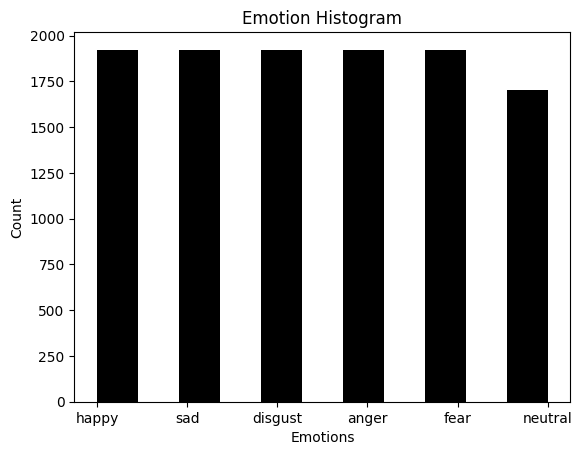

In [27]:
plt.title('Emotion Histogram')
plt.hist(df.emotion, color='black', bins=11)
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.show()

# 2. Data Processing

## 2.1. Data Augmentation

In [28]:
np.array(df.data)[50]

'data/crema-d/AudioWAV/1065_DFA_ANG_XX.wav'

In [29]:
path = np.array(df.data)[50]
data_sample, sample_rate = librosa.load(path)
np.array(df.emotion)[50]

'anger'

In [30]:
Audio(path)

In [31]:
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise

def augmentation(audio):
    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2),
        PitchShift(min_semitones=-1, max_semitones=1),
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0005),
    ])
    
    augmented_audio = augment(samples=audio, sample_rate=sample_rate)
    return augmented_audio

In [32]:
x = augmentation(data_sample)
print(np.array(df.emotion)[50])
Audio(x, rate=sample_rate)

anger


## 2.2. Feature Extraction

In [33]:
def extract_features(audio_data, sample_rate):    
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    rmse = librosa.feature.rms(y=audio_data)
    
    mean = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
    std = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)
    skewness = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
    kurtosis = librosa.feature.poly_features(y=audio_data, sr=sample_rate)
    
    ans = np.concatenate((mfccs, chroma, spectral_centroid, zcr, rmse, mean, std, skewness, kurtosis), axis=0)
    
    return ans.T

In [34]:
extract_features(data_sample, sample_rate).shape

(92, 66)

- Row : Timeframe
- Column : Features

In [35]:
df.shape[0]

11318

## 2.3. Data Processing

In [36]:
def data_processing(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.5)
    
    result = []
    for i in range(5):
        augmented_data = augmentation(data)
        features = extract_features(augmented_data, sample_rate)
        result.append(features)
    
    return np.array(result)

In [37]:
data_processing(df.iloc[1011, 0])[0].shape

(92, 66)

In [38]:
def create_features_file(i):
    end = i + 1000
    feature_path = os.path.join('data', 'feature')

    while i < end and i < len(df):
        features = data_processing(df.iloc[i, 0])
        j = 0
        for feature in features:
            file_name = 'np_' + str(i) + '_' + str(j) + '_' + df.iloc[i, 1] + '.npy'

            feature_save_path = os.path.join(feature_path, file_name)
            np.save(feature_save_path, feature)
            j += 1
            
        i += 1
        print(i, '/', min(end, len(df)), '-> DONE')

In [39]:
create_features_file(0)

1 / 1000 -> DONE
2 / 1000 -> DONE
3 / 1000 -> DONE
4 / 1000 -> DONE
5 / 1000 -> DONE
6 / 1000 -> DONE
7 / 1000 -> DONE
8 / 1000 -> DONE
9 / 1000 -> DONE
10 / 1000 -> DONE
11 / 1000 -> DONE
12 / 1000 -> DONE
13 / 1000 -> DONE
14 / 1000 -> DONE
15 / 1000 -> DONE
16 / 1000 -> DONE
17 / 1000 -> DONE
18 / 1000 -> DONE
19 / 1000 -> DONE
20 / 1000 -> DONE
21 / 1000 -> DONE
22 / 1000 -> DONE
23 / 1000 -> DONE
24 / 1000 -> DONE
25 / 1000 -> DONE
26 / 1000 -> DONE
27 / 1000 -> DONE
28 / 1000 -> DONE
29 / 1000 -> DONE
30 / 1000 -> DONE
31 / 1000 -> DONE
32 / 1000 -> DONE
33 / 1000 -> DONE
34 / 1000 -> DONE
35 / 1000 -> DONE
36 / 1000 -> DONE
37 / 1000 -> DONE
38 / 1000 -> DONE
39 / 1000 -> DONE
40 / 1000 -> DONE
41 / 1000 -> DONE
42 / 1000 -> DONE
43 / 1000 -> DONE
44 / 1000 -> DONE
45 / 1000 -> DONE
46 / 1000 -> DONE
47 / 1000 -> DONE
48 / 1000 -> DONE
49 / 1000 -> DONE
50 / 1000 -> DONE
51 / 1000 -> DONE
52 / 1000 -> DONE
53 / 1000 -> DONE
54 / 1000 -> DONE
55 / 1000 -> DONE
56 / 1000 -> DONE
5

438 / 1000 -> DONE
439 / 1000 -> DONE
440 / 1000 -> DONE
441 / 1000 -> DONE
442 / 1000 -> DONE
443 / 1000 -> DONE
444 / 1000 -> DONE
445 / 1000 -> DONE
446 / 1000 -> DONE
447 / 1000 -> DONE
448 / 1000 -> DONE
449 / 1000 -> DONE
450 / 1000 -> DONE
451 / 1000 -> DONE
452 / 1000 -> DONE
453 / 1000 -> DONE
454 / 1000 -> DONE
455 / 1000 -> DONE
456 / 1000 -> DONE
457 / 1000 -> DONE
458 / 1000 -> DONE
459 / 1000 -> DONE
460 / 1000 -> DONE
461 / 1000 -> DONE
462 / 1000 -> DONE
463 / 1000 -> DONE
464 / 1000 -> DONE
465 / 1000 -> DONE
466 / 1000 -> DONE
467 / 1000 -> DONE
468 / 1000 -> DONE
469 / 1000 -> DONE
470 / 1000 -> DONE
471 / 1000 -> DONE
472 / 1000 -> DONE
473 / 1000 -> DONE
474 / 1000 -> DONE
475 / 1000 -> DONE
476 / 1000 -> DONE
477 / 1000 -> DONE
478 / 1000 -> DONE
479 / 1000 -> DONE
480 / 1000 -> DONE
481 / 1000 -> DONE
482 / 1000 -> DONE
483 / 1000 -> DONE
484 / 1000 -> DONE
485 / 1000 -> DONE
486 / 1000 -> DONE
487 / 1000 -> DONE
488 / 1000 -> DONE
489 / 1000 -> DONE
490 / 1000 -

870 / 1000 -> DONE
871 / 1000 -> DONE
872 / 1000 -> DONE
873 / 1000 -> DONE
874 / 1000 -> DONE
875 / 1000 -> DONE
876 / 1000 -> DONE
877 / 1000 -> DONE
878 / 1000 -> DONE
879 / 1000 -> DONE
880 / 1000 -> DONE
881 / 1000 -> DONE
882 / 1000 -> DONE
883 / 1000 -> DONE
884 / 1000 -> DONE
885 / 1000 -> DONE
886 / 1000 -> DONE
887 / 1000 -> DONE
888 / 1000 -> DONE
889 / 1000 -> DONE
890 / 1000 -> DONE
891 / 1000 -> DONE
892 / 1000 -> DONE
893 / 1000 -> DONE
894 / 1000 -> DONE
895 / 1000 -> DONE
896 / 1000 -> DONE
897 / 1000 -> DONE
898 / 1000 -> DONE
899 / 1000 -> DONE
900 / 1000 -> DONE
901 / 1000 -> DONE
902 / 1000 -> DONE
903 / 1000 -> DONE
904 / 1000 -> DONE
905 / 1000 -> DONE
906 / 1000 -> DONE
907 / 1000 -> DONE
908 / 1000 -> DONE
909 / 1000 -> DONE
910 / 1000 -> DONE
911 / 1000 -> DONE
912 / 1000 -> DONE
913 / 1000 -> DONE
914 / 1000 -> DONE
915 / 1000 -> DONE
916 / 1000 -> DONE
917 / 1000 -> DONE
918 / 1000 -> DONE
919 / 1000 -> DONE
920 / 1000 -> DONE
921 / 1000 -> DONE
922 / 1000 -

In [40]:
create_features_file(1000)

1001 / 2000 -> DONE
1002 / 2000 -> DONE
1003 / 2000 -> DONE
1004 / 2000 -> DONE
1005 / 2000 -> DONE
1006 / 2000 -> DONE
1007 / 2000 -> DONE
1008 / 2000 -> DONE
1009 / 2000 -> DONE
1010 / 2000 -> DONE
1011 / 2000 -> DONE
1012 / 2000 -> DONE
1013 / 2000 -> DONE
1014 / 2000 -> DONE
1015 / 2000 -> DONE
1016 / 2000 -> DONE
1017 / 2000 -> DONE
1018 / 2000 -> DONE
1019 / 2000 -> DONE
1020 / 2000 -> DONE
1021 / 2000 -> DONE
1022 / 2000 -> DONE
1023 / 2000 -> DONE
1024 / 2000 -> DONE
1025 / 2000 -> DONE
1026 / 2000 -> DONE
1027 / 2000 -> DONE
1028 / 2000 -> DONE
1029 / 2000 -> DONE
1030 / 2000 -> DONE
1031 / 2000 -> DONE
1032 / 2000 -> DONE
1033 / 2000 -> DONE
1034 / 2000 -> DONE
1035 / 2000 -> DONE
1036 / 2000 -> DONE
1037 / 2000 -> DONE
1038 / 2000 -> DONE
1039 / 2000 -> DONE
1040 / 2000 -> DONE
1041 / 2000 -> DONE
1042 / 2000 -> DONE
1043 / 2000 -> DONE
1044 / 2000 -> DONE
1045 / 2000 -> DONE
1046 / 2000 -> DONE
1047 / 2000 -> DONE
1048 / 2000 -> DONE
1049 / 2000 -> DONE
1050 / 2000 -> DONE


1411 / 2000 -> DONE
1412 / 2000 -> DONE
1413 / 2000 -> DONE
1414 / 2000 -> DONE
1415 / 2000 -> DONE
1416 / 2000 -> DONE
1417 / 2000 -> DONE
1418 / 2000 -> DONE
1419 / 2000 -> DONE
1420 / 2000 -> DONE
1421 / 2000 -> DONE
1422 / 2000 -> DONE
1423 / 2000 -> DONE
1424 / 2000 -> DONE
1425 / 2000 -> DONE
1426 / 2000 -> DONE
1427 / 2000 -> DONE
1428 / 2000 -> DONE
1429 / 2000 -> DONE
1430 / 2000 -> DONE
1431 / 2000 -> DONE
1432 / 2000 -> DONE
1433 / 2000 -> DONE
1434 / 2000 -> DONE
1435 / 2000 -> DONE
1436 / 2000 -> DONE
1437 / 2000 -> DONE
1438 / 2000 -> DONE
1439 / 2000 -> DONE
1440 / 2000 -> DONE
1441 / 2000 -> DONE
1442 / 2000 -> DONE
1443 / 2000 -> DONE
1444 / 2000 -> DONE
1445 / 2000 -> DONE
1446 / 2000 -> DONE
1447 / 2000 -> DONE
1448 / 2000 -> DONE
1449 / 2000 -> DONE
1450 / 2000 -> DONE
1451 / 2000 -> DONE
1452 / 2000 -> DONE
1453 / 2000 -> DONE
1454 / 2000 -> DONE
1455 / 2000 -> DONE
1456 / 2000 -> DONE
1457 / 2000 -> DONE
1458 / 2000 -> DONE
1459 / 2000 -> DONE
1460 / 2000 -> DONE


1821 / 2000 -> DONE
1822 / 2000 -> DONE
1823 / 2000 -> DONE
1824 / 2000 -> DONE
1825 / 2000 -> DONE
1826 / 2000 -> DONE
1827 / 2000 -> DONE
1828 / 2000 -> DONE
1829 / 2000 -> DONE
1830 / 2000 -> DONE
1831 / 2000 -> DONE
1832 / 2000 -> DONE
1833 / 2000 -> DONE
1834 / 2000 -> DONE
1835 / 2000 -> DONE
1836 / 2000 -> DONE
1837 / 2000 -> DONE
1838 / 2000 -> DONE
1839 / 2000 -> DONE
1840 / 2000 -> DONE
1841 / 2000 -> DONE
1842 / 2000 -> DONE
1843 / 2000 -> DONE
1844 / 2000 -> DONE
1845 / 2000 -> DONE
1846 / 2000 -> DONE
1847 / 2000 -> DONE
1848 / 2000 -> DONE
1849 / 2000 -> DONE
1850 / 2000 -> DONE
1851 / 2000 -> DONE
1852 / 2000 -> DONE
1853 / 2000 -> DONE
1854 / 2000 -> DONE
1855 / 2000 -> DONE
1856 / 2000 -> DONE
1857 / 2000 -> DONE
1858 / 2000 -> DONE
1859 / 2000 -> DONE
1860 / 2000 -> DONE
1861 / 2000 -> DONE
1862 / 2000 -> DONE
1863 / 2000 -> DONE
1864 / 2000 -> DONE
1865 / 2000 -> DONE
1866 / 2000 -> DONE
1867 / 2000 -> DONE
1868 / 2000 -> DONE
1869 / 2000 -> DONE
1870 / 2000 -> DONE


/home/s4m0707/.conda/envs/tensorflow/lib/python3.9/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1907 / 2000 -> DONE
1908 / 2000 -> DONE
1909 / 2000 -> DONE
1910 / 2000 -> DONE
1911 / 2000 -> DONE
1912 / 2000 -> DONE
1913 / 2000 -> DONE
1914 / 2000 -> DONE
1915 / 2000 -> DONE
1916 / 2000 -> DONE
1917 / 2000 -> DONE
1918 / 2000 -> DONE
1919 / 2000 -> DONE
1920 / 2000 -> DONE
1921 / 2000 -> DONE
1922 / 2000 -> DONE
1923 / 2000 -> DONE
1924 / 2000 -> DONE
1925 / 2000 -> DONE
1926 / 2000 -> DONE
1927 / 2000 -> DONE
1928 / 2000 -> DONE
1929 / 2000 -> DONE
1930 / 2000 -> DONE
1931 / 2000 -> DONE
1932 / 2000 -> DONE
1933 / 2000 -> DONE
1934 / 2000 -> DONE
1935 / 2000 -> DONE
1936 / 2000 -> DONE
1937 / 2000 -> DONE
1938 / 2000 -> DONE
1939 / 2000 -> DONE
1940 / 2000 -> DONE
1941 / 2000 -> DONE
1942 / 2000 -> DONE
1943 / 2000 -> DONE
1944 / 2000 -> DONE
1945 / 2000 -> DONE
1946 / 2000 -> DONE
1947 / 2000 -> DONE
1948 / 2000 -> DONE
1949 / 2000 -> DONE
1950 / 2000 -> DONE
1951 / 2000 -> DONE
1952 / 2000 -> DONE
1953 / 2000 -> DONE
1954 / 2000 -> DONE
1955 / 2000 -> DONE
1956 / 2000 -> DONE


In [41]:
create_features_file(2000)

2001 / 3000 -> DONE
2002 / 3000 -> DONE
2003 / 3000 -> DONE
2004 / 3000 -> DONE
2005 / 3000 -> DONE
2006 / 3000 -> DONE
2007 / 3000 -> DONE
2008 / 3000 -> DONE
2009 / 3000 -> DONE
2010 / 3000 -> DONE
2011 / 3000 -> DONE
2012 / 3000 -> DONE
2013 / 3000 -> DONE
2014 / 3000 -> DONE
2015 / 3000 -> DONE
2016 / 3000 -> DONE
2017 / 3000 -> DONE
2018 / 3000 -> DONE
2019 / 3000 -> DONE
2020 / 3000 -> DONE
2021 / 3000 -> DONE
2022 / 3000 -> DONE
2023 / 3000 -> DONE
2024 / 3000 -> DONE
2025 / 3000 -> DONE
2026 / 3000 -> DONE
2027 / 3000 -> DONE
2028 / 3000 -> DONE
2029 / 3000 -> DONE
2030 / 3000 -> DONE
2031 / 3000 -> DONE
2032 / 3000 -> DONE
2033 / 3000 -> DONE
2034 / 3000 -> DONE
2035 / 3000 -> DONE
2036 / 3000 -> DONE
2037 / 3000 -> DONE
2038 / 3000 -> DONE
2039 / 3000 -> DONE
2040 / 3000 -> DONE
2041 / 3000 -> DONE
2042 / 3000 -> DONE
2043 / 3000 -> DONE
2044 / 3000 -> DONE
2045 / 3000 -> DONE
2046 / 3000 -> DONE
2047 / 3000 -> DONE
2048 / 3000 -> DONE
2049 / 3000 -> DONE
2050 / 3000 -> DONE


2411 / 3000 -> DONE
2412 / 3000 -> DONE
2413 / 3000 -> DONE
2414 / 3000 -> DONE
2415 / 3000 -> DONE
2416 / 3000 -> DONE
2417 / 3000 -> DONE
2418 / 3000 -> DONE
2419 / 3000 -> DONE
2420 / 3000 -> DONE
2421 / 3000 -> DONE
2422 / 3000 -> DONE
2423 / 3000 -> DONE
2424 / 3000 -> DONE
2425 / 3000 -> DONE
2426 / 3000 -> DONE
2427 / 3000 -> DONE
2428 / 3000 -> DONE
2429 / 3000 -> DONE
2430 / 3000 -> DONE
2431 / 3000 -> DONE
2432 / 3000 -> DONE
2433 / 3000 -> DONE
2434 / 3000 -> DONE
2435 / 3000 -> DONE
2436 / 3000 -> DONE
2437 / 3000 -> DONE
2438 / 3000 -> DONE
2439 / 3000 -> DONE
2440 / 3000 -> DONE
2441 / 3000 -> DONE
2442 / 3000 -> DONE
2443 / 3000 -> DONE
2444 / 3000 -> DONE
2445 / 3000 -> DONE
2446 / 3000 -> DONE
2447 / 3000 -> DONE
2448 / 3000 -> DONE
2449 / 3000 -> DONE
2450 / 3000 -> DONE
2451 / 3000 -> DONE
2452 / 3000 -> DONE
2453 / 3000 -> DONE
2454 / 3000 -> DONE
2455 / 3000 -> DONE
2456 / 3000 -> DONE
2457 / 3000 -> DONE
2458 / 3000 -> DONE
2459 / 3000 -> DONE
2460 / 3000 -> DONE


2821 / 3000 -> DONE
2822 / 3000 -> DONE
2823 / 3000 -> DONE
2824 / 3000 -> DONE
2825 / 3000 -> DONE
2826 / 3000 -> DONE
2827 / 3000 -> DONE
2828 / 3000 -> DONE
2829 / 3000 -> DONE
2830 / 3000 -> DONE
2831 / 3000 -> DONE
2832 / 3000 -> DONE
2833 / 3000 -> DONE
2834 / 3000 -> DONE
2835 / 3000 -> DONE
2836 / 3000 -> DONE
2837 / 3000 -> DONE
2838 / 3000 -> DONE
2839 / 3000 -> DONE
2840 / 3000 -> DONE
2841 / 3000 -> DONE
2842 / 3000 -> DONE
2843 / 3000 -> DONE
2844 / 3000 -> DONE
2845 / 3000 -> DONE
2846 / 3000 -> DONE
2847 / 3000 -> DONE
2848 / 3000 -> DONE
2849 / 3000 -> DONE
2850 / 3000 -> DONE
2851 / 3000 -> DONE
2852 / 3000 -> DONE
2853 / 3000 -> DONE
2854 / 3000 -> DONE
2855 / 3000 -> DONE
2856 / 3000 -> DONE
2857 / 3000 -> DONE
2858 / 3000 -> DONE
2859 / 3000 -> DONE
2860 / 3000 -> DONE
2861 / 3000 -> DONE
2862 / 3000 -> DONE
2863 / 3000 -> DONE
2864 / 3000 -> DONE
2865 / 3000 -> DONE
2866 / 3000 -> DONE
2867 / 3000 -> DONE
2868 / 3000 -> DONE
2869 / 3000 -> DONE
2870 / 3000 -> DONE


In [42]:
create_features_file(3000)

3001 / 4000 -> DONE
3002 / 4000 -> DONE
3003 / 4000 -> DONE
3004 / 4000 -> DONE
3005 / 4000 -> DONE
3006 / 4000 -> DONE
3007 / 4000 -> DONE
3008 / 4000 -> DONE
3009 / 4000 -> DONE
3010 / 4000 -> DONE
3011 / 4000 -> DONE
3012 / 4000 -> DONE
3013 / 4000 -> DONE
3014 / 4000 -> DONE
3015 / 4000 -> DONE
3016 / 4000 -> DONE
3017 / 4000 -> DONE
3018 / 4000 -> DONE
3019 / 4000 -> DONE
3020 / 4000 -> DONE
3021 / 4000 -> DONE
3022 / 4000 -> DONE
3023 / 4000 -> DONE
3024 / 4000 -> DONE
3025 / 4000 -> DONE
3026 / 4000 -> DONE
3027 / 4000 -> DONE
3028 / 4000 -> DONE
3029 / 4000 -> DONE
3030 / 4000 -> DONE
3031 / 4000 -> DONE
3032 / 4000 -> DONE
3033 / 4000 -> DONE
3034 / 4000 -> DONE
3035 / 4000 -> DONE
3036 / 4000 -> DONE
3037 / 4000 -> DONE
3038 / 4000 -> DONE
3039 / 4000 -> DONE
3040 / 4000 -> DONE
3041 / 4000 -> DONE
3042 / 4000 -> DONE
3043 / 4000 -> DONE
3044 / 4000 -> DONE
3045 / 4000 -> DONE
3046 / 4000 -> DONE
3047 / 4000 -> DONE
3048 / 4000 -> DONE
3049 / 4000 -> DONE
3050 / 4000 -> DONE


3411 / 4000 -> DONE
3412 / 4000 -> DONE
3413 / 4000 -> DONE
3414 / 4000 -> DONE
3415 / 4000 -> DONE
3416 / 4000 -> DONE
3417 / 4000 -> DONE
3418 / 4000 -> DONE
3419 / 4000 -> DONE
3420 / 4000 -> DONE
3421 / 4000 -> DONE
3422 / 4000 -> DONE
3423 / 4000 -> DONE
3424 / 4000 -> DONE
3425 / 4000 -> DONE
3426 / 4000 -> DONE
3427 / 4000 -> DONE
3428 / 4000 -> DONE
3429 / 4000 -> DONE
3430 / 4000 -> DONE
3431 / 4000 -> DONE
3432 / 4000 -> DONE
3433 / 4000 -> DONE
3434 / 4000 -> DONE
3435 / 4000 -> DONE
3436 / 4000 -> DONE
3437 / 4000 -> DONE
3438 / 4000 -> DONE
3439 / 4000 -> DONE
3440 / 4000 -> DONE
3441 / 4000 -> DONE
3442 / 4000 -> DONE
3443 / 4000 -> DONE
3444 / 4000 -> DONE
3445 / 4000 -> DONE
3446 / 4000 -> DONE
3447 / 4000 -> DONE
3448 / 4000 -> DONE
3449 / 4000 -> DONE
3450 / 4000 -> DONE
3451 / 4000 -> DONE
3452 / 4000 -> DONE
3453 / 4000 -> DONE
3454 / 4000 -> DONE
3455 / 4000 -> DONE
3456 / 4000 -> DONE
3457 / 4000 -> DONE
3458 / 4000 -> DONE
3459 / 4000 -> DONE
3460 / 4000 -> DONE


3821 / 4000 -> DONE
3822 / 4000 -> DONE
3823 / 4000 -> DONE
3824 / 4000 -> DONE
3825 / 4000 -> DONE
3826 / 4000 -> DONE
3827 / 4000 -> DONE
3828 / 4000 -> DONE
3829 / 4000 -> DONE
3830 / 4000 -> DONE
3831 / 4000 -> DONE
3832 / 4000 -> DONE
3833 / 4000 -> DONE
3834 / 4000 -> DONE
3835 / 4000 -> DONE
3836 / 4000 -> DONE
3837 / 4000 -> DONE
3838 / 4000 -> DONE
3839 / 4000 -> DONE
3840 / 4000 -> DONE
3841 / 4000 -> DONE
3842 / 4000 -> DONE
3843 / 4000 -> DONE
3844 / 4000 -> DONE
3845 / 4000 -> DONE
3846 / 4000 -> DONE
3847 / 4000 -> DONE
3848 / 4000 -> DONE
3849 / 4000 -> DONE
3850 / 4000 -> DONE
3851 / 4000 -> DONE
3852 / 4000 -> DONE
3853 / 4000 -> DONE
3854 / 4000 -> DONE
3855 / 4000 -> DONE
3856 / 4000 -> DONE
3857 / 4000 -> DONE
3858 / 4000 -> DONE
3859 / 4000 -> DONE
3860 / 4000 -> DONE
3861 / 4000 -> DONE
3862 / 4000 -> DONE
3863 / 4000 -> DONE
3864 / 4000 -> DONE
3865 / 4000 -> DONE
3866 / 4000 -> DONE
3867 / 4000 -> DONE
3868 / 4000 -> DONE
3869 / 4000 -> DONE
3870 / 4000 -> DONE


In [43]:
create_features_file(4000)

4001 / 5000 -> DONE
4002 / 5000 -> DONE
4003 / 5000 -> DONE
4004 / 5000 -> DONE
4005 / 5000 -> DONE
4006 / 5000 -> DONE
4007 / 5000 -> DONE
4008 / 5000 -> DONE
4009 / 5000 -> DONE
4010 / 5000 -> DONE
4011 / 5000 -> DONE
4012 / 5000 -> DONE
4013 / 5000 -> DONE
4014 / 5000 -> DONE
4015 / 5000 -> DONE
4016 / 5000 -> DONE
4017 / 5000 -> DONE
4018 / 5000 -> DONE
4019 / 5000 -> DONE
4020 / 5000 -> DONE
4021 / 5000 -> DONE
4022 / 5000 -> DONE
4023 / 5000 -> DONE
4024 / 5000 -> DONE
4025 / 5000 -> DONE
4026 / 5000 -> DONE
4027 / 5000 -> DONE
4028 / 5000 -> DONE
4029 / 5000 -> DONE
4030 / 5000 -> DONE
4031 / 5000 -> DONE
4032 / 5000 -> DONE
4033 / 5000 -> DONE
4034 / 5000 -> DONE
4035 / 5000 -> DONE
4036 / 5000 -> DONE
4037 / 5000 -> DONE
4038 / 5000 -> DONE
4039 / 5000 -> DONE
4040 / 5000 -> DONE
4041 / 5000 -> DONE
4042 / 5000 -> DONE
4043 / 5000 -> DONE
4044 / 5000 -> DONE
4045 / 5000 -> DONE
4046 / 5000 -> DONE
4047 / 5000 -> DONE
4048 / 5000 -> DONE
4049 / 5000 -> DONE
4050 / 5000 -> DONE


4411 / 5000 -> DONE
4412 / 5000 -> DONE
4413 / 5000 -> DONE
4414 / 5000 -> DONE
4415 / 5000 -> DONE
4416 / 5000 -> DONE
4417 / 5000 -> DONE
4418 / 5000 -> DONE
4419 / 5000 -> DONE
4420 / 5000 -> DONE
4421 / 5000 -> DONE
4422 / 5000 -> DONE
4423 / 5000 -> DONE
4424 / 5000 -> DONE
4425 / 5000 -> DONE
4426 / 5000 -> DONE
4427 / 5000 -> DONE
4428 / 5000 -> DONE
4429 / 5000 -> DONE
4430 / 5000 -> DONE
4431 / 5000 -> DONE
4432 / 5000 -> DONE
4433 / 5000 -> DONE
4434 / 5000 -> DONE
4435 / 5000 -> DONE
4436 / 5000 -> DONE
4437 / 5000 -> DONE
4438 / 5000 -> DONE
4439 / 5000 -> DONE
4440 / 5000 -> DONE
4441 / 5000 -> DONE
4442 / 5000 -> DONE
4443 / 5000 -> DONE
4444 / 5000 -> DONE
4445 / 5000 -> DONE
4446 / 5000 -> DONE
4447 / 5000 -> DONE
4448 / 5000 -> DONE
4449 / 5000 -> DONE
4450 / 5000 -> DONE
4451 / 5000 -> DONE
4452 / 5000 -> DONE
4453 / 5000 -> DONE
4454 / 5000 -> DONE
4455 / 5000 -> DONE
4456 / 5000 -> DONE
4457 / 5000 -> DONE
4458 / 5000 -> DONE
4459 / 5000 -> DONE
4460 / 5000 -> DONE


4821 / 5000 -> DONE
4822 / 5000 -> DONE
4823 / 5000 -> DONE
4824 / 5000 -> DONE
4825 / 5000 -> DONE
4826 / 5000 -> DONE
4827 / 5000 -> DONE
4828 / 5000 -> DONE
4829 / 5000 -> DONE
4830 / 5000 -> DONE
4831 / 5000 -> DONE
4832 / 5000 -> DONE
4833 / 5000 -> DONE
4834 / 5000 -> DONE
4835 / 5000 -> DONE
4836 / 5000 -> DONE
4837 / 5000 -> DONE
4838 / 5000 -> DONE
4839 / 5000 -> DONE
4840 / 5000 -> DONE
4841 / 5000 -> DONE
4842 / 5000 -> DONE
4843 / 5000 -> DONE
4844 / 5000 -> DONE
4845 / 5000 -> DONE
4846 / 5000 -> DONE
4847 / 5000 -> DONE
4848 / 5000 -> DONE
4849 / 5000 -> DONE
4850 / 5000 -> DONE
4851 / 5000 -> DONE
4852 / 5000 -> DONE
4853 / 5000 -> DONE
4854 / 5000 -> DONE
4855 / 5000 -> DONE
4856 / 5000 -> DONE
4857 / 5000 -> DONE
4858 / 5000 -> DONE
4859 / 5000 -> DONE
4860 / 5000 -> DONE
4861 / 5000 -> DONE
4862 / 5000 -> DONE
4863 / 5000 -> DONE
4864 / 5000 -> DONE
4865 / 5000 -> DONE
4866 / 5000 -> DONE
4867 / 5000 -> DONE
4868 / 5000 -> DONE
4869 / 5000 -> DONE
4870 / 5000 -> DONE


In [44]:
create_features_file(5000)

5001 / 6000 -> DONE
5002 / 6000 -> DONE
5003 / 6000 -> DONE
5004 / 6000 -> DONE
5005 / 6000 -> DONE
5006 / 6000 -> DONE
5007 / 6000 -> DONE
5008 / 6000 -> DONE
5009 / 6000 -> DONE
5010 / 6000 -> DONE
5011 / 6000 -> DONE
5012 / 6000 -> DONE
5013 / 6000 -> DONE
5014 / 6000 -> DONE
5015 / 6000 -> DONE
5016 / 6000 -> DONE
5017 / 6000 -> DONE
5018 / 6000 -> DONE
5019 / 6000 -> DONE
5020 / 6000 -> DONE
5021 / 6000 -> DONE
5022 / 6000 -> DONE
5023 / 6000 -> DONE
5024 / 6000 -> DONE
5025 / 6000 -> DONE
5026 / 6000 -> DONE
5027 / 6000 -> DONE
5028 / 6000 -> DONE
5029 / 6000 -> DONE
5030 / 6000 -> DONE
5031 / 6000 -> DONE
5032 / 6000 -> DONE
5033 / 6000 -> DONE
5034 / 6000 -> DONE
5035 / 6000 -> DONE
5036 / 6000 -> DONE
5037 / 6000 -> DONE
5038 / 6000 -> DONE
5039 / 6000 -> DONE
5040 / 6000 -> DONE
5041 / 6000 -> DONE
5042 / 6000 -> DONE
5043 / 6000 -> DONE
5044 / 6000 -> DONE
5045 / 6000 -> DONE
5046 / 6000 -> DONE
5047 / 6000 -> DONE
5048 / 6000 -> DONE
5049 / 6000 -> DONE
5050 / 6000 -> DONE


5411 / 6000 -> DONE
5412 / 6000 -> DONE
5413 / 6000 -> DONE
5414 / 6000 -> DONE
5415 / 6000 -> DONE
5416 / 6000 -> DONE
5417 / 6000 -> DONE
5418 / 6000 -> DONE
5419 / 6000 -> DONE
5420 / 6000 -> DONE
5421 / 6000 -> DONE
5422 / 6000 -> DONE
5423 / 6000 -> DONE
5424 / 6000 -> DONE
5425 / 6000 -> DONE
5426 / 6000 -> DONE
5427 / 6000 -> DONE
5428 / 6000 -> DONE
5429 / 6000 -> DONE
5430 / 6000 -> DONE
5431 / 6000 -> DONE
5432 / 6000 -> DONE
5433 / 6000 -> DONE
5434 / 6000 -> DONE
5435 / 6000 -> DONE
5436 / 6000 -> DONE
5437 / 6000 -> DONE
5438 / 6000 -> DONE
5439 / 6000 -> DONE
5440 / 6000 -> DONE
5441 / 6000 -> DONE
5442 / 6000 -> DONE
5443 / 6000 -> DONE
5444 / 6000 -> DONE
5445 / 6000 -> DONE
5446 / 6000 -> DONE
5447 / 6000 -> DONE
5448 / 6000 -> DONE
5449 / 6000 -> DONE
5450 / 6000 -> DONE
5451 / 6000 -> DONE
5452 / 6000 -> DONE
5453 / 6000 -> DONE
5454 / 6000 -> DONE
5455 / 6000 -> DONE
5456 / 6000 -> DONE
5457 / 6000 -> DONE
5458 / 6000 -> DONE
5459 / 6000 -> DONE
5460 / 6000 -> DONE


5821 / 6000 -> DONE
5822 / 6000 -> DONE
5823 / 6000 -> DONE
5824 / 6000 -> DONE
5825 / 6000 -> DONE
5826 / 6000 -> DONE
5827 / 6000 -> DONE
5828 / 6000 -> DONE
5829 / 6000 -> DONE
5830 / 6000 -> DONE
5831 / 6000 -> DONE
5832 / 6000 -> DONE
5833 / 6000 -> DONE
5834 / 6000 -> DONE
5835 / 6000 -> DONE
5836 / 6000 -> DONE
5837 / 6000 -> DONE
5838 / 6000 -> DONE
5839 / 6000 -> DONE
5840 / 6000 -> DONE
5841 / 6000 -> DONE
5842 / 6000 -> DONE
5843 / 6000 -> DONE
5844 / 6000 -> DONE
5845 / 6000 -> DONE
5846 / 6000 -> DONE
5847 / 6000 -> DONE
5848 / 6000 -> DONE
5849 / 6000 -> DONE
5850 / 6000 -> DONE
5851 / 6000 -> DONE
5852 / 6000 -> DONE
5853 / 6000 -> DONE
5854 / 6000 -> DONE
5855 / 6000 -> DONE
5856 / 6000 -> DONE
5857 / 6000 -> DONE
5858 / 6000 -> DONE
5859 / 6000 -> DONE
5860 / 6000 -> DONE
5861 / 6000 -> DONE
5862 / 6000 -> DONE
5863 / 6000 -> DONE
5864 / 6000 -> DONE
5865 / 6000 -> DONE
5866 / 6000 -> DONE
5867 / 6000 -> DONE
5868 / 6000 -> DONE
5869 / 6000 -> DONE
5870 / 6000 -> DONE


In [45]:
create_features_file(6000)

6001 / 7000 -> DONE
6002 / 7000 -> DONE
6003 / 7000 -> DONE
6004 / 7000 -> DONE
6005 / 7000 -> DONE
6006 / 7000 -> DONE
6007 / 7000 -> DONE
6008 / 7000 -> DONE
6009 / 7000 -> DONE
6010 / 7000 -> DONE
6011 / 7000 -> DONE
6012 / 7000 -> DONE
6013 / 7000 -> DONE
6014 / 7000 -> DONE
6015 / 7000 -> DONE
6016 / 7000 -> DONE
6017 / 7000 -> DONE
6018 / 7000 -> DONE
6019 / 7000 -> DONE
6020 / 7000 -> DONE
6021 / 7000 -> DONE
6022 / 7000 -> DONE
6023 / 7000 -> DONE
6024 / 7000 -> DONE
6025 / 7000 -> DONE
6026 / 7000 -> DONE
6027 / 7000 -> DONE
6028 / 7000 -> DONE
6029 / 7000 -> DONE
6030 / 7000 -> DONE
6031 / 7000 -> DONE
6032 / 7000 -> DONE
6033 / 7000 -> DONE
6034 / 7000 -> DONE
6035 / 7000 -> DONE
6036 / 7000 -> DONE
6037 / 7000 -> DONE
6038 / 7000 -> DONE
6039 / 7000 -> DONE
6040 / 7000 -> DONE
6041 / 7000 -> DONE
6042 / 7000 -> DONE
6043 / 7000 -> DONE
6044 / 7000 -> DONE
6045 / 7000 -> DONE
6046 / 7000 -> DONE
6047 / 7000 -> DONE
6048 / 7000 -> DONE
6049 / 7000 -> DONE
6050 / 7000 -> DONE


6411 / 7000 -> DONE
6412 / 7000 -> DONE
6413 / 7000 -> DONE
6414 / 7000 -> DONE
6415 / 7000 -> DONE
6416 / 7000 -> DONE
6417 / 7000 -> DONE
6418 / 7000 -> DONE
6419 / 7000 -> DONE
6420 / 7000 -> DONE
6421 / 7000 -> DONE
6422 / 7000 -> DONE
6423 / 7000 -> DONE
6424 / 7000 -> DONE
6425 / 7000 -> DONE
6426 / 7000 -> DONE
6427 / 7000 -> DONE
6428 / 7000 -> DONE
6429 / 7000 -> DONE
6430 / 7000 -> DONE
6431 / 7000 -> DONE
6432 / 7000 -> DONE
6433 / 7000 -> DONE
6434 / 7000 -> DONE
6435 / 7000 -> DONE
6436 / 7000 -> DONE
6437 / 7000 -> DONE
6438 / 7000 -> DONE
6439 / 7000 -> DONE
6440 / 7000 -> DONE
6441 / 7000 -> DONE
6442 / 7000 -> DONE
6443 / 7000 -> DONE
6444 / 7000 -> DONE
6445 / 7000 -> DONE
6446 / 7000 -> DONE
6447 / 7000 -> DONE
6448 / 7000 -> DONE
6449 / 7000 -> DONE
6450 / 7000 -> DONE
6451 / 7000 -> DONE
6452 / 7000 -> DONE
6453 / 7000 -> DONE
6454 / 7000 -> DONE
6455 / 7000 -> DONE
6456 / 7000 -> DONE
6457 / 7000 -> DONE
6458 / 7000 -> DONE
6459 / 7000 -> DONE
6460 / 7000 -> DONE


6821 / 7000 -> DONE
6822 / 7000 -> DONE
6823 / 7000 -> DONE
6824 / 7000 -> DONE
6825 / 7000 -> DONE
6826 / 7000 -> DONE
6827 / 7000 -> DONE
6828 / 7000 -> DONE
6829 / 7000 -> DONE
6830 / 7000 -> DONE
6831 / 7000 -> DONE
6832 / 7000 -> DONE
6833 / 7000 -> DONE
6834 / 7000 -> DONE
6835 / 7000 -> DONE
6836 / 7000 -> DONE
6837 / 7000 -> DONE
6838 / 7000 -> DONE
6839 / 7000 -> DONE
6840 / 7000 -> DONE
6841 / 7000 -> DONE
6842 / 7000 -> DONE
6843 / 7000 -> DONE
6844 / 7000 -> DONE
6845 / 7000 -> DONE
6846 / 7000 -> DONE
6847 / 7000 -> DONE
6848 / 7000 -> DONE
6849 / 7000 -> DONE
6850 / 7000 -> DONE
6851 / 7000 -> DONE
6852 / 7000 -> DONE
6853 / 7000 -> DONE
6854 / 7000 -> DONE
6855 / 7000 -> DONE
6856 / 7000 -> DONE
6857 / 7000 -> DONE
6858 / 7000 -> DONE
6859 / 7000 -> DONE
6860 / 7000 -> DONE
6861 / 7000 -> DONE
6862 / 7000 -> DONE
6863 / 7000 -> DONE
6864 / 7000 -> DONE
6865 / 7000 -> DONE
6866 / 7000 -> DONE
6867 / 7000 -> DONE
6868 / 7000 -> DONE
6869 / 7000 -> DONE
6870 / 7000 -> DONE


In [46]:
create_features_file(7000)

7001 / 8000 -> DONE
7002 / 8000 -> DONE
7003 / 8000 -> DONE
7004 / 8000 -> DONE
7005 / 8000 -> DONE
7006 / 8000 -> DONE
7007 / 8000 -> DONE
7008 / 8000 -> DONE
7009 / 8000 -> DONE
7010 / 8000 -> DONE
7011 / 8000 -> DONE
7012 / 8000 -> DONE
7013 / 8000 -> DONE
7014 / 8000 -> DONE
7015 / 8000 -> DONE
7016 / 8000 -> DONE
7017 / 8000 -> DONE
7018 / 8000 -> DONE
7019 / 8000 -> DONE
7020 / 8000 -> DONE
7021 / 8000 -> DONE
7022 / 8000 -> DONE
7023 / 8000 -> DONE
7024 / 8000 -> DONE
7025 / 8000 -> DONE
7026 / 8000 -> DONE
7027 / 8000 -> DONE
7028 / 8000 -> DONE
7029 / 8000 -> DONE
7030 / 8000 -> DONE
7031 / 8000 -> DONE
7032 / 8000 -> DONE
7033 / 8000 -> DONE
7034 / 8000 -> DONE
7035 / 8000 -> DONE
7036 / 8000 -> DONE
7037 / 8000 -> DONE
7038 / 8000 -> DONE
7039 / 8000 -> DONE
7040 / 8000 -> DONE
7041 / 8000 -> DONE
7042 / 8000 -> DONE
7043 / 8000 -> DONE
7044 / 8000 -> DONE
7045 / 8000 -> DONE
7046 / 8000 -> DONE
7047 / 8000 -> DONE
7048 / 8000 -> DONE
7049 / 8000 -> DONE
7050 / 8000 -> DONE


7411 / 8000 -> DONE
7412 / 8000 -> DONE
7413 / 8000 -> DONE
7414 / 8000 -> DONE
7415 / 8000 -> DONE
7416 / 8000 -> DONE
7417 / 8000 -> DONE
7418 / 8000 -> DONE
7419 / 8000 -> DONE
7420 / 8000 -> DONE
7421 / 8000 -> DONE
7422 / 8000 -> DONE
7423 / 8000 -> DONE
7424 / 8000 -> DONE
7425 / 8000 -> DONE
7426 / 8000 -> DONE
7427 / 8000 -> DONE
7428 / 8000 -> DONE
7429 / 8000 -> DONE
7430 / 8000 -> DONE
7431 / 8000 -> DONE
7432 / 8000 -> DONE
7433 / 8000 -> DONE
7434 / 8000 -> DONE
7435 / 8000 -> DONE
7436 / 8000 -> DONE
7437 / 8000 -> DONE
7438 / 8000 -> DONE
7439 / 8000 -> DONE
7440 / 8000 -> DONE
7441 / 8000 -> DONE
7442 / 8000 -> DONE
7443 / 8000 -> DONE
7444 / 8000 -> DONE
7445 / 8000 -> DONE
7446 / 8000 -> DONE
7447 / 8000 -> DONE
7448 / 8000 -> DONE
7449 / 8000 -> DONE
7450 / 8000 -> DONE
7451 / 8000 -> DONE
7452 / 8000 -> DONE
7453 / 8000 -> DONE
7454 / 8000 -> DONE
7455 / 8000 -> DONE
7456 / 8000 -> DONE
7457 / 8000 -> DONE
7458 / 8000 -> DONE
7459 / 8000 -> DONE
7460 / 8000 -> DONE


7821 / 8000 -> DONE
7822 / 8000 -> DONE
7823 / 8000 -> DONE
7824 / 8000 -> DONE
7825 / 8000 -> DONE
7826 / 8000 -> DONE
7827 / 8000 -> DONE
7828 / 8000 -> DONE
7829 / 8000 -> DONE
7830 / 8000 -> DONE
7831 / 8000 -> DONE
7832 / 8000 -> DONE
7833 / 8000 -> DONE
7834 / 8000 -> DONE
7835 / 8000 -> DONE
7836 / 8000 -> DONE
7837 / 8000 -> DONE
7838 / 8000 -> DONE
7839 / 8000 -> DONE
7840 / 8000 -> DONE
7841 / 8000 -> DONE
7842 / 8000 -> DONE
7843 / 8000 -> DONE
7844 / 8000 -> DONE
7845 / 8000 -> DONE
7846 / 8000 -> DONE
7847 / 8000 -> DONE
7848 / 8000 -> DONE
7849 / 8000 -> DONE
7850 / 8000 -> DONE
7851 / 8000 -> DONE
7852 / 8000 -> DONE
7853 / 8000 -> DONE
7854 / 8000 -> DONE
7855 / 8000 -> DONE
7856 / 8000 -> DONE
7857 / 8000 -> DONE
7858 / 8000 -> DONE
7859 / 8000 -> DONE
7860 / 8000 -> DONE
7861 / 8000 -> DONE
7862 / 8000 -> DONE
7863 / 8000 -> DONE
7864 / 8000 -> DONE
7865 / 8000 -> DONE
7866 / 8000 -> DONE
7867 / 8000 -> DONE
7868 / 8000 -> DONE
7869 / 8000 -> DONE
7870 / 8000 -> DONE


In [47]:
create_features_file(8000)

8001 / 9000 -> DONE
8002 / 9000 -> DONE
8003 / 9000 -> DONE
8004 / 9000 -> DONE
8005 / 9000 -> DONE
8006 / 9000 -> DONE
8007 / 9000 -> DONE
8008 / 9000 -> DONE
8009 / 9000 -> DONE
8010 / 9000 -> DONE
8011 / 9000 -> DONE
8012 / 9000 -> DONE
8013 / 9000 -> DONE
8014 / 9000 -> DONE
8015 / 9000 -> DONE
8016 / 9000 -> DONE
8017 / 9000 -> DONE
8018 / 9000 -> DONE
8019 / 9000 -> DONE
8020 / 9000 -> DONE
8021 / 9000 -> DONE
8022 / 9000 -> DONE
8023 / 9000 -> DONE
8024 / 9000 -> DONE
8025 / 9000 -> DONE
8026 / 9000 -> DONE
8027 / 9000 -> DONE
8028 / 9000 -> DONE
8029 / 9000 -> DONE
8030 / 9000 -> DONE
8031 / 9000 -> DONE
8032 / 9000 -> DONE
8033 / 9000 -> DONE
8034 / 9000 -> DONE
8035 / 9000 -> DONE
8036 / 9000 -> DONE
8037 / 9000 -> DONE
8038 / 9000 -> DONE
8039 / 9000 -> DONE
8040 / 9000 -> DONE
8041 / 9000 -> DONE
8042 / 9000 -> DONE
8043 / 9000 -> DONE
8044 / 9000 -> DONE
8045 / 9000 -> DONE
8046 / 9000 -> DONE
8047 / 9000 -> DONE
8048 / 9000 -> DONE
8049 / 9000 -> DONE
8050 / 9000 -> DONE


8411 / 9000 -> DONE
8412 / 9000 -> DONE
8413 / 9000 -> DONE
8414 / 9000 -> DONE
8415 / 9000 -> DONE
8416 / 9000 -> DONE
8417 / 9000 -> DONE
8418 / 9000 -> DONE
8419 / 9000 -> DONE
8420 / 9000 -> DONE
8421 / 9000 -> DONE
8422 / 9000 -> DONE
8423 / 9000 -> DONE
8424 / 9000 -> DONE
8425 / 9000 -> DONE
8426 / 9000 -> DONE
8427 / 9000 -> DONE
8428 / 9000 -> DONE
8429 / 9000 -> DONE
8430 / 9000 -> DONE
8431 / 9000 -> DONE
8432 / 9000 -> DONE
8433 / 9000 -> DONE
8434 / 9000 -> DONE
8435 / 9000 -> DONE
8436 / 9000 -> DONE
8437 / 9000 -> DONE
8438 / 9000 -> DONE
8439 / 9000 -> DONE
8440 / 9000 -> DONE
8441 / 9000 -> DONE
8442 / 9000 -> DONE
8443 / 9000 -> DONE
8444 / 9000 -> DONE
8445 / 9000 -> DONE
8446 / 9000 -> DONE
8447 / 9000 -> DONE
8448 / 9000 -> DONE
8449 / 9000 -> DONE
8450 / 9000 -> DONE
8451 / 9000 -> DONE
8452 / 9000 -> DONE
8453 / 9000 -> DONE
8454 / 9000 -> DONE
8455 / 9000 -> DONE
8456 / 9000 -> DONE
8457 / 9000 -> DONE
8458 / 9000 -> DONE
8459 / 9000 -> DONE
8460 / 9000 -> DONE


8821 / 9000 -> DONE
8822 / 9000 -> DONE
8823 / 9000 -> DONE
8824 / 9000 -> DONE
8825 / 9000 -> DONE
8826 / 9000 -> DONE
8827 / 9000 -> DONE
8828 / 9000 -> DONE
8829 / 9000 -> DONE
8830 / 9000 -> DONE
8831 / 9000 -> DONE
8832 / 9000 -> DONE
8833 / 9000 -> DONE
8834 / 9000 -> DONE
8835 / 9000 -> DONE
8836 / 9000 -> DONE
8837 / 9000 -> DONE
8838 / 9000 -> DONE
8839 / 9000 -> DONE
8840 / 9000 -> DONE
8841 / 9000 -> DONE
8842 / 9000 -> DONE
8843 / 9000 -> DONE
8844 / 9000 -> DONE
8845 / 9000 -> DONE
8846 / 9000 -> DONE
8847 / 9000 -> DONE
8848 / 9000 -> DONE
8849 / 9000 -> DONE
8850 / 9000 -> DONE
8851 / 9000 -> DONE
8852 / 9000 -> DONE
8853 / 9000 -> DONE
8854 / 9000 -> DONE
8855 / 9000 -> DONE
8856 / 9000 -> DONE
8857 / 9000 -> DONE
8858 / 9000 -> DONE
8859 / 9000 -> DONE
8860 / 9000 -> DONE
8861 / 9000 -> DONE
8862 / 9000 -> DONE
8863 / 9000 -> DONE
8864 / 9000 -> DONE
8865 / 9000 -> DONE
8866 / 9000 -> DONE
8867 / 9000 -> DONE
8868 / 9000 -> DONE
8869 / 9000 -> DONE
8870 / 9000 -> DONE


In [48]:
create_features_file(9000)

9001 / 10000 -> DONE
9002 / 10000 -> DONE
9003 / 10000 -> DONE
9004 / 10000 -> DONE
9005 / 10000 -> DONE
9006 / 10000 -> DONE
9007 / 10000 -> DONE
9008 / 10000 -> DONE
9009 / 10000 -> DONE
9010 / 10000 -> DONE
9011 / 10000 -> DONE
9012 / 10000 -> DONE
9013 / 10000 -> DONE
9014 / 10000 -> DONE
9015 / 10000 -> DONE
9016 / 10000 -> DONE
9017 / 10000 -> DONE
9018 / 10000 -> DONE
9019 / 10000 -> DONE
9020 / 10000 -> DONE
9021 / 10000 -> DONE
9022 / 10000 -> DONE
9023 / 10000 -> DONE
9024 / 10000 -> DONE
9025 / 10000 -> DONE
9026 / 10000 -> DONE
9027 / 10000 -> DONE
9028 / 10000 -> DONE
9029 / 10000 -> DONE
9030 / 10000 -> DONE
9031 / 10000 -> DONE
9032 / 10000 -> DONE
9033 / 10000 -> DONE
9034 / 10000 -> DONE
9035 / 10000 -> DONE
9036 / 10000 -> DONE
9037 / 10000 -> DONE
9038 / 10000 -> DONE
9039 / 10000 -> DONE
9040 / 10000 -> DONE
9041 / 10000 -> DONE
9042 / 10000 -> DONE
9043 / 10000 -> DONE
9044 / 10000 -> DONE
9045 / 10000 -> DONE
9046 / 10000 -> DONE
9047 / 10000 -> DONE
9048 / 10000 

9392 / 10000 -> DONE
9393 / 10000 -> DONE
9394 / 10000 -> DONE
9395 / 10000 -> DONE
9396 / 10000 -> DONE
9397 / 10000 -> DONE
9398 / 10000 -> DONE
9399 / 10000 -> DONE
9400 / 10000 -> DONE
9401 / 10000 -> DONE
9402 / 10000 -> DONE
9403 / 10000 -> DONE
9404 / 10000 -> DONE
9405 / 10000 -> DONE
9406 / 10000 -> DONE
9407 / 10000 -> DONE
9408 / 10000 -> DONE
9409 / 10000 -> DONE
9410 / 10000 -> DONE
9411 / 10000 -> DONE
9412 / 10000 -> DONE
9413 / 10000 -> DONE
9414 / 10000 -> DONE
9415 / 10000 -> DONE
9416 / 10000 -> DONE
9417 / 10000 -> DONE
9418 / 10000 -> DONE
9419 / 10000 -> DONE
9420 / 10000 -> DONE
9421 / 10000 -> DONE
9422 / 10000 -> DONE
9423 / 10000 -> DONE
9424 / 10000 -> DONE
9425 / 10000 -> DONE
9426 / 10000 -> DONE
9427 / 10000 -> DONE
9428 / 10000 -> DONE
9429 / 10000 -> DONE
9430 / 10000 -> DONE
9431 / 10000 -> DONE
9432 / 10000 -> DONE
9433 / 10000 -> DONE
9434 / 10000 -> DONE
9435 / 10000 -> DONE
9436 / 10000 -> DONE
9437 / 10000 -> DONE
9438 / 10000 -> DONE
9439 / 10000 

9783 / 10000 -> DONE
9784 / 10000 -> DONE
9785 / 10000 -> DONE
9786 / 10000 -> DONE
9787 / 10000 -> DONE
9788 / 10000 -> DONE
9789 / 10000 -> DONE
9790 / 10000 -> DONE
9791 / 10000 -> DONE
9792 / 10000 -> DONE
9793 / 10000 -> DONE
9794 / 10000 -> DONE
9795 / 10000 -> DONE
9796 / 10000 -> DONE
9797 / 10000 -> DONE
9798 / 10000 -> DONE
9799 / 10000 -> DONE
9800 / 10000 -> DONE
9801 / 10000 -> DONE
9802 / 10000 -> DONE
9803 / 10000 -> DONE
9804 / 10000 -> DONE
9805 / 10000 -> DONE
9806 / 10000 -> DONE
9807 / 10000 -> DONE
9808 / 10000 -> DONE
9809 / 10000 -> DONE
9810 / 10000 -> DONE
9811 / 10000 -> DONE
9812 / 10000 -> DONE
9813 / 10000 -> DONE
9814 / 10000 -> DONE
9815 / 10000 -> DONE
9816 / 10000 -> DONE
9817 / 10000 -> DONE
9818 / 10000 -> DONE
9819 / 10000 -> DONE
9820 / 10000 -> DONE
9821 / 10000 -> DONE
9822 / 10000 -> DONE
9823 / 10000 -> DONE
9824 / 10000 -> DONE
9825 / 10000 -> DONE
9826 / 10000 -> DONE
9827 / 10000 -> DONE
9828 / 10000 -> DONE
9829 / 10000 -> DONE
9830 / 10000 

In [49]:
create_features_file(10000)

10001 / 11000 -> DONE
10002 / 11000 -> DONE
10003 / 11000 -> DONE
10004 / 11000 -> DONE
10005 / 11000 -> DONE
10006 / 11000 -> DONE
10007 / 11000 -> DONE
10008 / 11000 -> DONE
10009 / 11000 -> DONE
10010 / 11000 -> DONE
10011 / 11000 -> DONE
10012 / 11000 -> DONE
10013 / 11000 -> DONE
10014 / 11000 -> DONE
10015 / 11000 -> DONE
10016 / 11000 -> DONE
10017 / 11000 -> DONE
10018 / 11000 -> DONE
10019 / 11000 -> DONE
10020 / 11000 -> DONE
10021 / 11000 -> DONE
10022 / 11000 -> DONE
10023 / 11000 -> DONE
10024 / 11000 -> DONE
10025 / 11000 -> DONE
10026 / 11000 -> DONE
10027 / 11000 -> DONE
10028 / 11000 -> DONE
10029 / 11000 -> DONE
10030 / 11000 -> DONE
10031 / 11000 -> DONE
10032 / 11000 -> DONE
10033 / 11000 -> DONE
10034 / 11000 -> DONE
10035 / 11000 -> DONE
10036 / 11000 -> DONE
10037 / 11000 -> DONE
10038 / 11000 -> DONE
10039 / 11000 -> DONE
10040 / 11000 -> DONE
10041 / 11000 -> DONE
10042 / 11000 -> DONE
10043 / 11000 -> DONE
10044 / 11000 -> DONE
10045 / 11000 -> DONE
10046 / 11

10374 / 11000 -> DONE
10375 / 11000 -> DONE
10376 / 11000 -> DONE
10377 / 11000 -> DONE
10378 / 11000 -> DONE
10379 / 11000 -> DONE
10380 / 11000 -> DONE
10381 / 11000 -> DONE
10382 / 11000 -> DONE
10383 / 11000 -> DONE
10384 / 11000 -> DONE
10385 / 11000 -> DONE
10386 / 11000 -> DONE
10387 / 11000 -> DONE
10388 / 11000 -> DONE
10389 / 11000 -> DONE
10390 / 11000 -> DONE
10391 / 11000 -> DONE
10392 / 11000 -> DONE
10393 / 11000 -> DONE
10394 / 11000 -> DONE
10395 / 11000 -> DONE
10396 / 11000 -> DONE
10397 / 11000 -> DONE
10398 / 11000 -> DONE
10399 / 11000 -> DONE
10400 / 11000 -> DONE
10401 / 11000 -> DONE
10402 / 11000 -> DONE
10403 / 11000 -> DONE
10404 / 11000 -> DONE
10405 / 11000 -> DONE
10406 / 11000 -> DONE
10407 / 11000 -> DONE
10408 / 11000 -> DONE
10409 / 11000 -> DONE
10410 / 11000 -> DONE
10411 / 11000 -> DONE
10412 / 11000 -> DONE
10413 / 11000 -> DONE
10414 / 11000 -> DONE
10415 / 11000 -> DONE
10416 / 11000 -> DONE
10417 / 11000 -> DONE
10418 / 11000 -> DONE
10419 / 11

10747 / 11000 -> DONE
10748 / 11000 -> DONE
10749 / 11000 -> DONE
10750 / 11000 -> DONE
10751 / 11000 -> DONE
10752 / 11000 -> DONE
10753 / 11000 -> DONE
10754 / 11000 -> DONE
10755 / 11000 -> DONE
10756 / 11000 -> DONE
10757 / 11000 -> DONE
10758 / 11000 -> DONE
10759 / 11000 -> DONE
10760 / 11000 -> DONE
10761 / 11000 -> DONE
10762 / 11000 -> DONE
10763 / 11000 -> DONE
10764 / 11000 -> DONE
10765 / 11000 -> DONE
10766 / 11000 -> DONE
10767 / 11000 -> DONE
10768 / 11000 -> DONE
10769 / 11000 -> DONE
10770 / 11000 -> DONE
10771 / 11000 -> DONE
10772 / 11000 -> DONE
10773 / 11000 -> DONE
10774 / 11000 -> DONE
10775 / 11000 -> DONE
10776 / 11000 -> DONE
10777 / 11000 -> DONE
10778 / 11000 -> DONE
10779 / 11000 -> DONE
10780 / 11000 -> DONE
10781 / 11000 -> DONE
10782 / 11000 -> DONE
10783 / 11000 -> DONE
10784 / 11000 -> DONE
10785 / 11000 -> DONE
10786 / 11000 -> DONE
10787 / 11000 -> DONE
10788 / 11000 -> DONE
10789 / 11000 -> DONE
10790 / 11000 -> DONE
10791 / 11000 -> DONE
10792 / 11

In [50]:
create_features_file(11000)

11001 / 11318 -> DONE
11002 / 11318 -> DONE
11003 / 11318 -> DONE
11004 / 11318 -> DONE
11005 / 11318 -> DONE
11006 / 11318 -> DONE
11007 / 11318 -> DONE
11008 / 11318 -> DONE
11009 / 11318 -> DONE
11010 / 11318 -> DONE
11011 / 11318 -> DONE
11012 / 11318 -> DONE
11013 / 11318 -> DONE
11014 / 11318 -> DONE
11015 / 11318 -> DONE
11016 / 11318 -> DONE
11017 / 11318 -> DONE
11018 / 11318 -> DONE
11019 / 11318 -> DONE
11020 / 11318 -> DONE
11021 / 11318 -> DONE
11022 / 11318 -> DONE
11023 / 11318 -> DONE
11024 / 11318 -> DONE
11025 / 11318 -> DONE
11026 / 11318 -> DONE
11027 / 11318 -> DONE
11028 / 11318 -> DONE
11029 / 11318 -> DONE
11030 / 11318 -> DONE
11031 / 11318 -> DONE
11032 / 11318 -> DONE
11033 / 11318 -> DONE
11034 / 11318 -> DONE
11035 / 11318 -> DONE
11036 / 11318 -> DONE
11037 / 11318 -> DONE
11038 / 11318 -> DONE
11039 / 11318 -> DONE
11040 / 11318 -> DONE
11041 / 11318 -> DONE
11042 / 11318 -> DONE
11043 / 11318 -> DONE
11044 / 11318 -> DONE
11045 / 11318 -> DONE
11046 / 11

# 3. Dataset

In [169]:
feature_dir = os.path.join('data', 'feature')

i = 0
for x in os.listdir(feature_dir):
    print(x.split('_')[-1][0:-4])
    
    if i > 5:
        break
    i += 1

fear
fear
neutral
neutral
fear
fear
neutral


In [170]:
emotion_class = {'fear' : 0,
                 'anger' : 1,
                 'happy' : 2,
                 'disgust' : 3,
                 'sad' : 4,
                 'neutral' : 5
                }

In [171]:
n_rows = 110

def generator():
    for npy_file in os.listdir(feature_dir):
        npy_pth = os.path.join(feature_dir, npy_file)
        
        label = npy_file.split('_')[-1][0:-4]
        
        data = np.load(npy_pth)
        data = np.pad(data, ((0, n_rows - data.shape[0]), (0, 0)), 'constant', constant_values=0)
            
        yield data, emotion_class[label]

In [172]:
numpy_dataset = tf.data.Dataset.from_generator(
    generator,
    output_types=(tf.float64, tf.int32),
    output_shapes=((n_rows, 66), ())
)

In [173]:
for file in numpy_dataset.take(1):
    print(file)

(<tf.Tensor: shape=(110, 66), dtype=float64, numpy=
array([[-4.73865417e+02,  1.02491096e+02,  4.00142441e+01, ...,
         1.46051682e+01, -1.10859092e-05,  9.11187712e-02],
       [-4.62586365e+02,  9.94942017e+01,  4.87455750e+01, ...,
         1.46036525e+01, -1.56322984e-05,  1.26171459e-01],
       [-4.74713135e+02,  9.77382202e+01,  5.84581375e+01, ...,
         1.36021657e+01, -1.60484637e-05,  1.28787008e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


## 3.1. One Hot Encoding

In [174]:
def one_hot_encoding(datapoint, label):
    num_classes = len(emotion_class)

    one_hot_label = tf.one_hot(label, depth=num_classes)
    
    return (datapoint, one_hot_label)

In [176]:
numpy_dataset = numpy_dataset.map(one_hot_encoding)

for file in numpy_dataset.take(3):
    print(file)

(<tf.Tensor: shape=(110, 66), dtype=float64, numpy=
array([[-4.73865417e+02,  1.02491096e+02,  4.00142441e+01, ...,
         1.46051682e+01, -1.10859092e-05,  9.11187712e-02],
       [-4.62586365e+02,  9.94942017e+01,  4.87455750e+01, ...,
         1.46036525e+01, -1.56322984e-05,  1.26171459e-01],
       [-4.74713135e+02,  9.77382202e+01,  5.84581375e+01, ...,
         1.36021657e+01, -1.60484637e-05,  1.28787008e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(110, 66), dtype=float64, numpy=
array([[-4.68250977e+02,  1.14951843e+02,  

## 3.1. Train Val Test Split

In [177]:
numpy_count = 56590
numpy_count

56590

In [178]:
train_ds = numpy_dataset.take(int(numpy_count * 0.6))
remaining_ds = numpy_dataset.skip(int(numpy_count * 0.6))

remaining_count = 22636
remaining_count

22636

In [179]:
val_ds = remaining_ds.take(int(remaining_count * 0.5))
test_ds = remaining_ds.skip(int(remaining_count * 0.5))

In [ ]:
train_ds = train_ds.shuffle(123).batch(256)